In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata
from datetime import datetime
from scipy import stats


In [2]:
############### Synthetic Data #############
β = 0.005
μ2 = 1/21 #14 days infectious
μ1 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ϵ = 0.0001
capT = 10000
γ = 1/(80*365)
Input_H = [1500,1,0,0]
parameters = [Input_H, capT] 

In [3]:
def gillespieSEIR(initial, beta, mu1,mu2, sigma, epsilon,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]>0):
        state = np.zeros(shape= (4,4))
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0]
        
        R_ir = mu2*pop[ind][2]
        state[:,2] = [0,0,-1,1]

        R_is = mu1*pop[ind][2]
        state[:,3] = [1,0,-1,0]

        
        rate = [R_se, R_ei, R_ir, R_is]

        Rtotal = sum(rate)
#         print(Rtotal)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
#         total_inf = sum(cuminf)
        if event == 1:
            cuminf.append(1 + cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:3])
    return event_time, np.array(pop), events, cuminf

In [7]:
M =gillespieSEIR(parameters[0], β, μ1, μ2, σ, ϵ,  parameters[1])
time = [] #make results of M a step function
cuminf = [] #steps
for ind, x in enumerate(M[0]):
    if ind < len(M[0])-1:
        time.append((M[0][ind], M[0][ind+1]))
        cuminf.append((M[3][ind], M[3][ind]))
time = np.array(time).flatten()
cuminf = np.array(cuminf).flatten()
max_inf = max(cuminf)
max_time = math.ceil(max(time))


intert = np.arange(0, max_time +1 , 1) #interpolate to daily steps
intercum = np.interp(intert, time,cuminf) #daily steps


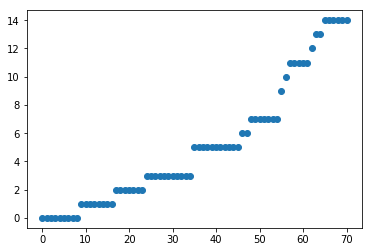

In [8]:
intercum = [0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  9., 10., 11., 11., 11., 11., 11., 12., 13., 13.,
        14., 14., 14., 14., 14., 14.]
intert = range(len(intercum))
plt.plot(range(len(intercum)), intercum, 'o')

In [8]:
intert = np.array(intert, dtype = int)
intercum

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  7.,  7.,  7.,  7.,
        7.,  7.,  7.,  9., 10., 11., 11., 11., 11., 11., 12., 13., 13.,
       14., 14., 14., 14., 14., 14.])

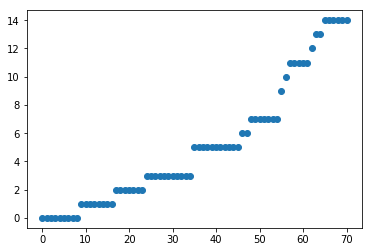

In [15]:
plt.plot(intert, intercum, 'o') # This is the synthetic data
summary = np.array([[int(a) for a in intert], [int(b) for b in intercum]])

# Perform ABC on the synthetic data

In [10]:
N = 200
tol = 50
t = 0 
θ = []

β1, ɛ1, σ1, μ11,μ21 =  [np.random.uniform(0,0.1, N), np.random.uniform(0,0.001, N),
                     1/np.random.uniform(1,30, N), 1/np.random.uniform(1, 40, N),
                     1/np.random.uniform(1,40, N)]
#     print(np.array([β1, ɛ1, p1 ]))

θ = [np.array([β1, ɛ1, σ1, μ11, μ21]).T]
# print(θ[0][:,0])
t = 1
θ_t = []
tols = []
tols.append(tol)
error = []
while t< 6:
    r_β = np.random.randint(0, N-1)
    r_ϵ = np.random.randint(0,N-1)
    r_σ= np.random.randint(0,N-1)
    r_μ1 = np.random.randint(0,N-1)
    r_μ2 = np.random.randint(0,N-1)
    δ = np.random.uniform(0, 1e-3)
    βt, ɛt, σt, μ1t, μ2t = θ[t-1][:,0][r_β] +δ, θ[t-1][:,1][r_ϵ] +δ,θ[t-1][:,2][r_σ] + δ, θ[t-1][:,3][r_μ1] +δ, θ[t-1][:,4][r_μ2] +δ

    M =gillespieSEIR(parameters[0], βt, μ1t,μ2t,σt,ɛt,  parameters[1])
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(M[0]):
        if ind < len(M[0])-1:
            time.append((M[0][ind], M[0][ind+1]))
            cuminf.append((M[3][ind], M[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
#     print(max_inf, max_time, βt, ɛt)
    

    summary_time = summary[0]
#         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = summary[1]
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 3)
        summary_time = np.append(summary_time, length1)
#         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max(summary[1])*np.ones(len(length1 )))
#         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 3)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) #daily steps
    
#         print(summary_time, summary_cum)
#     print(np.linalg.norm(summary_cum-inter_cum[summary_time]), βt, ɛt, pt)
    if np.linalg.norm(summary_cum-inter_cum[summary_time]) <tol:
        θ_t.append(np.array([βt, ɛt, σt, μ1t, μ2t]))
        print(len(θ_t), t, tol, np.linalg.norm(summary_cum-inter_cum[summary_time]))
#             θ_t = np.array(θ_t)
#             print(θ_t)
        error.append(np.linalg.norm(summary_cum-inter_cum[summary_time]))
    if len(θ_t) == N:
        tol = np.median(error)
        tols.append(tol)
        θ_t = np.array(θ_t)
        print(θ_t)
        θ.append(θ_t)
        t +=1 
        θ_t = []
        error = []

1 1 50 28.965496715920477
2 1 50 33.46640106136302
3 1 50 40.44749683231337
4 1 50 25.65151067676132
5 1 50 40.74309757492672
6 1 50 45.67274898667694
7 1 50 40.4103947023535
8 1 50 40.36087214122113
9 1 50 41.036569057366385
10 1 50 30.066592756745816
11 1 50 40.3732584763727
12 1 50 45.79301256742124
13 1 50 39.96248240537617
14 1 50 45.2658811910251
15 1 50 41.7492514902962
16 1 50 45.552167895721496
17 1 50 40.496913462633174
18 1 50 45.44227107000705
19 1 50 45.2658811910251
20 1 50 45.4972526643093
21 1 50 45.36518488885502
22 1 50 41.02438299353203
23 1 50 30.692018506445613
24 1 50 34.46737587922817
25 1 50 33.8673884437522
26 1 50 45.58508528016593
27 1 50 31.96873472629156
28 1 50 40.58324777540605
29 1 50 45.39823785126467
30 1 50 39.89987468652001
31 1 50 45.4972526643093
32 1 50 10.583005244258363
33 1 50 38.47076812334269
34 1 50 36.6333181680284
35 1 50 41.19465984809196
36 1 50 40.92676385936225
37 1 50 44.955533585978046
38 1 50 37.429934544425805
39 1 50 29.8998327754

1 2 40.14348827576208 29.614185789921695
2 2 40.14348827576208 31.71750305430741
3 2 40.14348827576208 36.6742416417845
4 2 40.14348827576208 36.71511950137164
5 2 40.14348827576208 35.6931365951495
6 2 40.14348827576208 33.075670817082454
7 2 40.14348827576208 32.7566787083184
8 2 40.14348827576208 30.347981810987037
9 2 40.14348827576208 39.11521443121589
10 2 40.14348827576208 37.469987990390386
11 2 40.14348827576208 34.77067730142742
12 2 40.14348827576208 38.897300677553446
13 2 40.14348827576208 35.608987629529715
14 2 40.14348827576208 34.40930106817051
15 2 40.14348827576208 35.270384177096794
16 2 40.14348827576208 35.199431813596085
17 2 40.14348827576208 35.08560958569767
18 2 40.14348827576208 32.60368077380221
19 2 40.14348827576208 36.4828726939094
20 2 40.14348827576208 38.157568056677825
21 2 40.14348827576208 36.05551275463989
22 2 40.14348827576208 31.906112267087632
23 2 40.14348827576208 35.17101079013795
24 2 40.14348827576208 32.12475680841802
25 2 40.14348827576

199 2 40.14348827576208 36.180105030251084
200 2 40.14348827576208 36.53765181289022
[[4.60306919e-02 1.42772441e-04 1.79817496e-01 5.35733867e-01
  4.55835925e-01]
 [1.72297365e-03 2.25057913e-04 2.31472812e-01 5.34942281e-01
  4.34147047e-02]
 [1.24091626e-02 1.84413416e-04 2.12381040e-01 1.59975330e-01
  9.64743333e-02]
 [1.97549168e-02 2.70301992e-04 2.42691930e-01 4.48309718e-02
  3.23395822e-01]
 [2.33379124e-02 8.02358032e-04 4.55994022e-01 4.64837064e-02
  4.36542050e-01]
 [2.08405728e-02 2.52206783e-04 1.79983492e-01 7.07297258e-02
  4.34768191e-02]
 [2.69867890e-02 1.66993774e-04 2.09248842e-01 5.46607619e-01
  3.23222213e-01]
 [7.16162501e-02 2.71797071e-04 1.51614587e-01 3.01360713e-02
  4.36564435e-01]
 [5.48433397e-02 3.09360236e-04 1.81418830e-01 7.73248041e-01
  7.13605430e-02]
 [2.12568728e-02 3.81259174e-04 4.55897253e-01 3.13729130e-02
  3.23425821e-01]
 [2.09553826e-02 1.43847639e-04 6.75606605e-01 2.71037228e-02
  2.06882779e-01]
 [1.72423511e-02 3.94009976e-04 4.1

1 3 34.65544389904849 33.71943060017473
2 3 34.65544389904849 31.670175244226233
3 3 34.65544389904849 23.194827009486403
4 3 34.65544389904849 32.78719262151
5 3 34.65544389904849 28.792360097775937
6 3 34.65544389904849 32.2335229225724
7 3 34.65544389904849 34.219877264537345
8 3 34.65544389904849 30.83828789021855
9 3 34.65544389904849 16.61324772583615
10 3 34.65544389904849 33.97057550292606
11 3 34.65544389904849 34.62657938636157
12 3 34.65544389904849 32.449961479175904
13 3 34.65544389904849 31.496031496047245
14 3 34.65544389904849 34.11744421846396
15 3 34.65544389904849 28.792360097775937
16 3 34.65544389904849 18.81488772222678
17 3 34.65544389904849 34.46737587922817
18 3 34.65544389904849 33.481338085566414
19 3 34.65544389904849 25.826343140289914
20 3 34.65544389904849 34.11744421846396
21 3 34.65544389904849 33.03028912982749
22 3 34.65544389904849 13.711309200802088
23 3 34.65544389904849 32.38826948140329
24 3 34.65544389904849 34.307433596816885
25 3 34.6554438990

198 3 34.65544389904849 34.61213659975356
199 3 34.65544389904849 30.4138126514911
200 3 34.65544389904849 34.11744421846396
[[3.05072700e-02 4.19782201e-04 2.61825003e-01 5.35333976e-01
  2.82838919e-02]
 [6.73339776e-02 3.37733500e-04 3.20344322e-01 2.53390791e-01
  1.28400778e-01]
 [1.24874316e-02 1.91078709e-04 1.80124447e-01 6.12543195e-01
  1.18619419e-01]
 [6.72173403e-02 3.60205833e-04 4.99858870e-01 1.56905101e-01
  3.23643302e-01]
 [2.35710289e-02 1.24703300e-04 1.19772365e-01 3.11089939e-02
  4.22423278e-01]
 [3.80517473e-02 3.60605268e-04 1.82035199e-01 7.73444694e-01
  2.11578269e-01]
 [4.07902763e-02 3.35898878e-04 2.13290733e-01 5.35927984e-01
  4.36170445e-01]
 [6.23332094e-03 1.53297486e-04 1.32956462e-01 5.35842311e-01
  3.85586427e-02]
 [2.29232076e-02 1.56943506e-04 1.27732554e-01 4.79625683e-02
  1.80870699e-01]
 [5.51450705e-02 4.84779369e-04 3.21189284e-01 2.53172077e-01
  4.36294485e-01]
 [2.13096168e-02 1.31056833e-04 1.32783616e-01 6.70650442e-02
  5.45278286e

1 4 32.91656030505867 32.49615361854384
2 4 32.91656030505867 31.670175244226233
3 4 32.91656030505867 32.83291031876401
4 4 32.91656030505867 32.526911934581186
5 4 32.91656030505867 23.302360395462088
6 4 32.91656030505867 30.44667469527666
7 4 32.91656030505867 30.805843601498726
8 4 32.91656030505867 32.14031735997639
9 4 32.91656030505867 32.218007387174026
10 4 32.91656030505867 29.24038303442689
11 4 32.91656030505867 32.17141588429082
12 4 32.91656030505867 29.614185789921695
13 4 32.91656030505867 29.512709126747414
14 4 32.91656030505867 25.612496949731394
15 4 32.91656030505867 32.863353450309965
16 4 32.91656030505867 32.72613634390714
17 4 32.91656030505867 32.68026927673638
18 4 32.91656030505867 32.77193921634788
19 4 32.91656030505867 27.055498516937366
20 4 32.91656030505867 28.19574435974337
21 4 32.91656030505867 32.37282811247729
22 4 32.91656030505867 32.848135411313685
23 4 32.91656030505867 32.64965543462902
24 4 32.91656030505867 31.04834939252005
25 4 32.916560

197 4 32.91656030505867 30.01666203960727
198 4 32.91656030505867 31.496031496047245
199 4 32.91656030505867 32.90896534380867
200 4 32.91656030505867 29.086079144497972
[[5.51896772e-02 1.96501498e-04 1.81447529e-01 3.02173296e-02
  1.84856737e-01]
 [7.23103783e-02 3.04011699e-04 1.80389424e-01 5.35105325e-01
  3.01709181e-02]
 [3.78145491e-02 2.39129651e-04 1.52446617e-01 5.46755914e-01
  2.66620464e-02]
 [1.34598982e-03 2.96979906e-04 1.75948061e-01 7.73351593e-01
  4.36790187e-01]
 [5.27776440e-02 1.46609063e-04 1.27810459e-01 7.82173515e-02
  1.28227702e-01]
 [6.81461505e-02 4.70871174e-04 2.42720080e-01 8.80015731e-01
  5.20452178e-01]
 [2.61631936e-02 4.15006549e-04 1.80177510e-01 9.42548486e-02
  1.63048324e-01]
 [5.28231609e-02 2.35952267e-04 2.31870088e-01 3.68797459e-02
  2.07265460e-01]
 [2.33456872e-02 3.30471392e-04 2.73258095e-01 3.55238809e-02
  4.56594655e-01]
 [8.70911244e-02 2.01313553e-04 1.80313494e-01 5.47028901e-01
  9.11793513e-02]
 [2.14772964e-02 2.54583959e-0

1 5 31.44041079495728 31.0322412983658
2 5 31.44041079495728 23.769728648009426
3 5 31.44041079495728 30.033314835362415
4 5 31.44041079495728 28.495613697550013
5 5 31.44041079495728 30.62678566222711
6 5 31.44041079495728 30.166206257996713
7 5 31.44041079495728 30.347981810987037
8 5 31.44041079495728 22.24859546128699
9 5 31.44041079495728 31.064449134018133
10 5 31.44041079495728 30.347981810987037
11 5 31.44041079495728 28.827070610799147
12 5 31.44041079495728 24.228082879171435
13 5 31.44041079495728 30.62678566222711
14 5 31.44041079495728 23.874672772626646
15 5 31.44041079495728 28.948229652260256
16 5 31.44041079495728 31.32091952673165
17 5 31.44041079495728 18.083141320025124
18 5 31.44041079495728 30.708305065568176
19 5 31.44041079495728 30.430248109405877
20 5 31.44041079495728 28.635642126552707
21 5 31.44041079495728 31.192947920964443
22 5 31.44041079495728 29.8496231131986
23 5 31.44041079495728 22.47220505424423
24 5 31.44041079495728 30.983866769659336
25 5 31.44

196 5 31.44041079495728 31.32091952673165
197 5 31.44041079495728 27.92848008753788
198 5 31.44041079495728 27.386127875258307
199 5 31.44041079495728 30.298514815086232
200 5 31.44041079495728 31.080540535840107
[[2.80546368e-02 2.15461560e-04 2.09768608e-01 3.50285746e-02
  4.36299938e-01]
 [3.29253174e-02 1.86175160e-04 2.09721030e-01 1.57044111e-01
  4.56685239e-01]
 [9.16427841e-02 2.49771480e-04 1.80177726e-01 5.46792618e-01
  4.36324281e-01]
 [9.01778887e-02 3.60536780e-04 2.31897796e-01 8.80043439e-01
  1.28602606e-01]
 [2.81827657e-02 3.25524497e-04 1.33129046e-01 8.80491721e-01
  5.37176502e-01]
 [2.15510707e-02 2.85501834e-04 1.75864168e-01 5.33758308e-02
  5.37149775e-01]
 [4.78994311e-02 3.00766559e-04 2.48935335e-01 5.36558531e-01
  2.11640345e-01]
 [6.71669634e-02 1.74781340e-04 1.07850040e-01 7.73222736e-01
  4.36291370e-01]
 [4.78937748e-02 1.82312640e-04 2.31925595e-01 9.44987297e-02
  1.28250173e-01]
 [2.16414517e-02 3.79174699e-04 2.32601775e-01 1.60180004e-01
  6.5

In [ ]:
len(summary_cum)
len(inter_cum)
summary_time

In [9]:
θ = np.load('theta_synthetic_SEIR_200.npy')
tols = np.load('tols_synthetic_SEIR_200.npy')

In [11]:
# np.save('theta_synthetic_SEIR_200', θ)
# np.save('tols_synthetic_SEIR_200', tols)

/home/emma/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


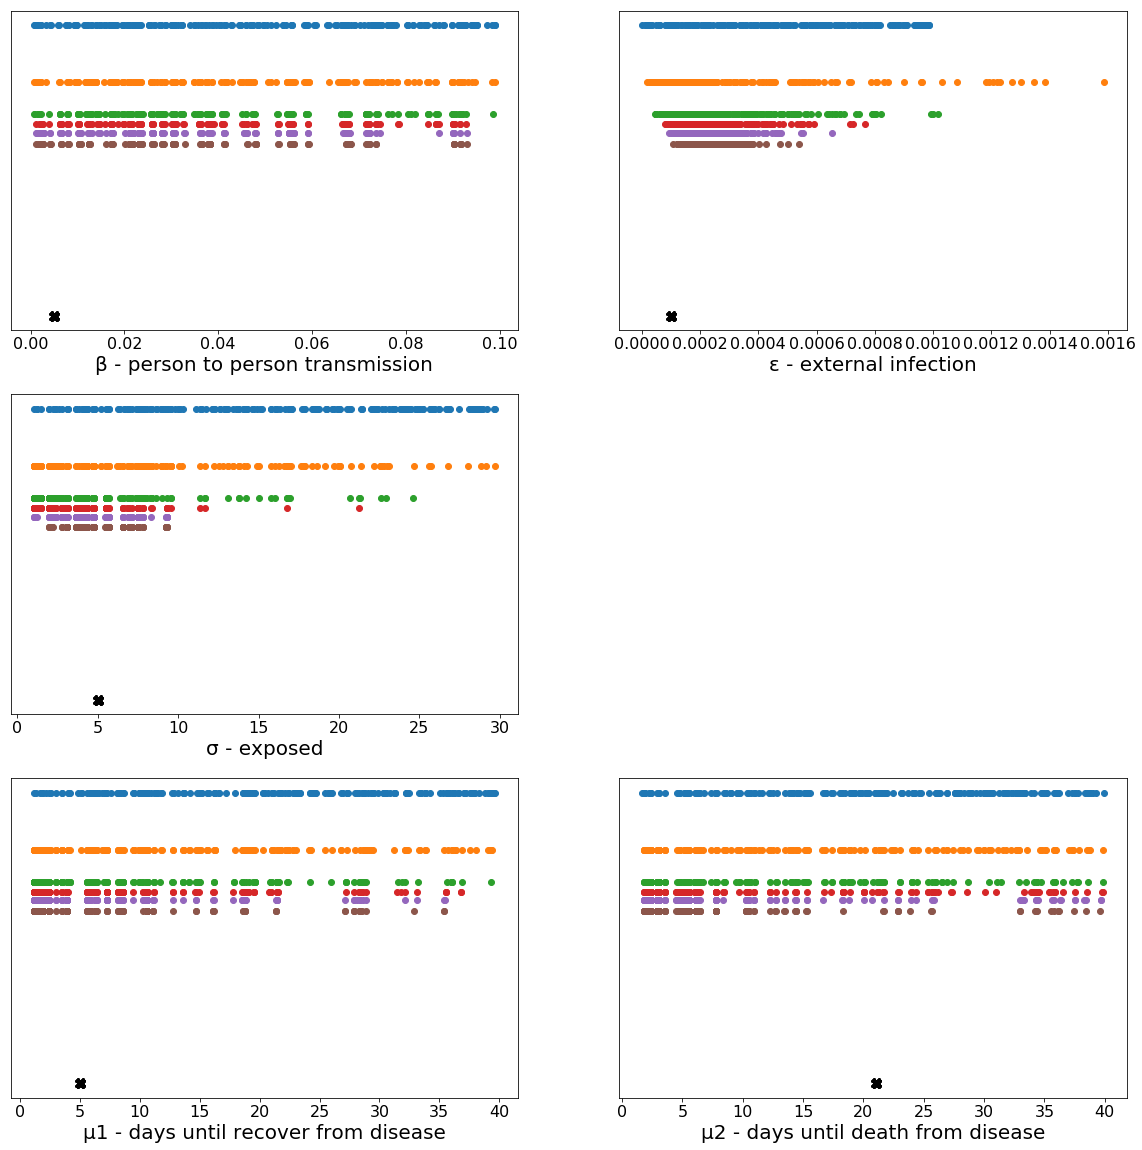

In [10]:
plt.figure(figsize = (20,20))
tol = 6
for i in range(6):
    plt.subplot(3,2,1)
    plt.plot(θ[i][:,0], tols[i]*np.ones(200), 'o' )
    plt.xlabel('β - person to person transmission', fontsize = 20)
    plt.plot(β, 0, 'X',markersize = 10, color = 'k')
    plt.yticks([])
    plt.xticks(fontsize = 16)
    
    plt.subplot(3,2,2)
    plt.plot(θ[i][:,1], tols[i]*np.ones(200), 'o' )
    plt.xlabel('ɛ - external infection', fontsize = 20)
    plt.plot(ϵ, 0, 'X',markersize = 10, color = 'k')
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,3)
    plt.plot([1/a for a in θ[i][:,2]], tols[i]*np.ones(200), 'o' )
    plt.xlabel('σ - exposed', fontsize = 20)
    plt.plot(1/σ, 0, 'X',markersize = 10, color = 'k')
    plt.yticks([])
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,5)
    plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(200), 'o' )
    plt.xlabel('μ1 - days until recover from disease', fontsize = 20)
    plt.plot(1/μ1, 0, 'X',markersize = 10, color = 'k')
    plt.yticks([])        
    plt.xticks(fontsize = 16)

    plt.subplot(3,2,6)
    plt.plot([1/b for b in θ[i][:,4]] , tols[i]*np.ones(200), 'o' )
    plt.xlabel('μ2 - days until death from disease', fontsize = 20)
    plt.plot(1/μ2, 0, 'X',markersize = 10, color = 'k')

    plt.yticks([])        
    plt.xticks(fontsize = 16)
    

/home/emma/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([-20., -10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 9 Text xticklabel objects>)

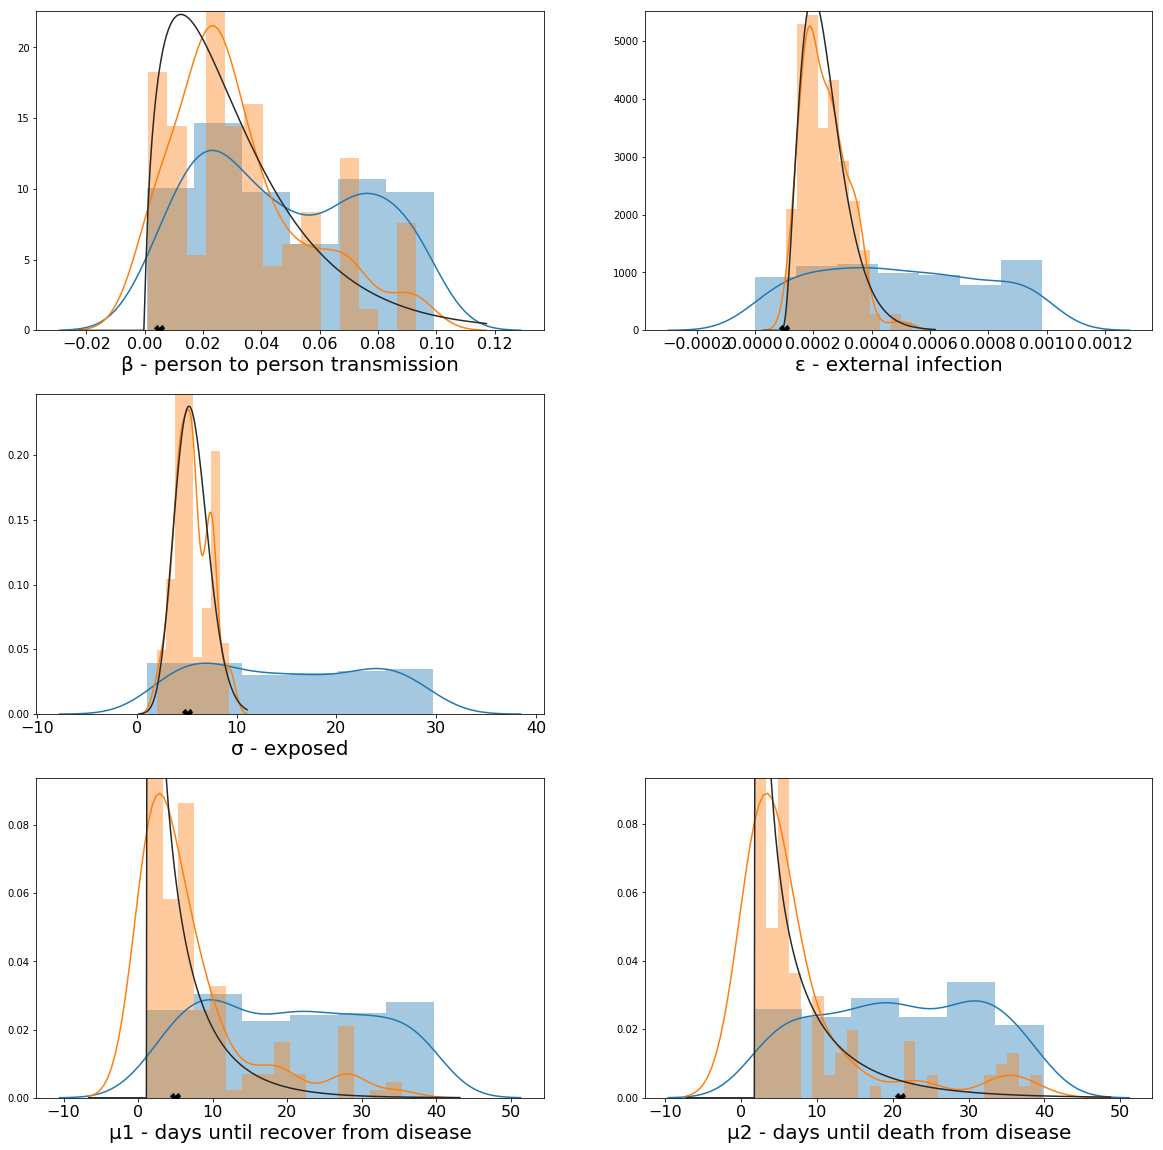

In [11]:
plt.figure(figsize = (20,20))

plt.subplot(3,2,1)
#     plt.plot(θ[i][:,0], tols[i]*np.ones(50), 'o' )
sns.distplot(θ[0][:,0],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,0],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.plot(β, 0, 'X',markersize = 10, color = 'k')
plt.xlabel('β - person to person transmission', fontsize = 20)
# plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,2)
#     plt.plot(θ[i][:,1], tols[i]*np.ones(50), 'o' )
sns.distplot(θ[0][:,1],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot(θ[5][:,1],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.plot(ϵ, 0, 'X',markersize = 10, color = 'k')
plt.xlabel('ɛ - external infection', fontsize = 20)
# plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,3)
#     plt.plot([1/a for a in θ[i][:,2]], tols[i]*np.ones(50), 'o' )
sns.distplot([1/a for a in θ[0][:,2]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[5][:,2]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('σ - exposed', fontsize = 20)
plt.plot(1/σ, 0, 'X',markersize = 10, color = 'k')
# plt.yticks([])
plt.xticks(fontsize = 16)

plt.subplot(3,2,5)
sns.distplot([1/a for a in θ[0][:,3]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[5][:,3]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
# plt.plot([1/b for b in θ[i][:,3]] , tols[i]*np.ones(50), 'o' )
plt.plot(1/μ1, 0, 'X',markersize = 10, color = 'k')
plt.xlabel('μ1 - days until recover from disease', fontsize = 20)
# plt.yticks([])        
plt.xticks(fontsize = 16)

plt.subplot(3,2,6)
#     plt.plot([1/b for b in θ[i][:,4]] , tols[i]*np.ones(50), 'o' )
sns.distplot([1/a for a in θ[0][:,4]],  kde=True,  norm_hist=False, label = 'Prior')
sns.distplot([1/a for a in θ[5][:,4]],  kde=True,  norm_hist=False, fit=stats.gamma, label = 'Posterior')
plt.xlabel('μ2 - days until death from disease', fontsize = 20)
plt.plot(1/μ2, 0, 'X',markersize = 10, color = 'k')
# plt.yticks([])        
plt.xticks(fontsize = 16)


In [52]:
a_β, loc_β, scale_β = stats.gamma.fit(θ[5][:,0])
a_ϵ, loc_ϵ, scale_ϵ = stats.gamma.fit(θ[5][:,1])
a_σ, loc_σ, scale_σ = stats.gamma.fit([1/a for a in θ[5][:,2]])
a_μ1, loc_μ1, scale_μ1 = stats.gamma.fit([1/a for a in θ[5][:,3]])
a_μ2, loc_μ2, scale_μ2 = stats.gamma.fit([1/a for a in θ[5][:,4]])

In [68]:
1/stats.gamma.rvs(a_μ2, loc_μ2, scale_μ2)
# 1/(67*365)

0.07224605486131379

# Test the ABC on synthetic data

In [16]:
parameters = [Input_H, capT]
r_β = np.random.randint(0, 199)
r_ϵ = np.random.randint(0,199)
r_σ = np.random.randint(0,199)
r_μ1 = np.random.randint(0,199)
r_μ2 = np.random.randint(0,199)
betas = θ[5][:,0]
eps = θ[5][:,1]
sigmas = θ[5][:,2]
mus1 = θ[5][:,3]
mus2 = θ[5][:,4]

In [17]:
Rec_syn = summary[0]
Cum_syn = summary[1]
len_syn = len(Rec_syn)

In [54]:
timing = []
cumulative = []
for k in range(1000):
#     r_β = np.random.randint(0, 199)
#     r_ϵ = np.random.randint(0,199)
#     r_σ = np.random.randint(0,199)
#     r_μ1 = np.random.randint(0,199)
#     r_μ2 = np.random.randint(0,199)
#     M=gillespieSEIR(parameters[0], betas[r_β], mus1[r_μ1],mus2[r_μ2],
#                           sigmas[r_σ],eps[r_ϵ],  parameters[1])

    beta = stats.gamma.rvs( a_β, loc_β, scale_β)
    mu1 = 1/stats.gamma.rvs( a_μ1, loc_μ1, scale_μ1)
    mu2 = 1/stats.gamma.rvs( a_μ2, loc_μ2, scale_μ2)
    epsilon = stats.gamma.rvs( a_ϵ, loc_ϵ, scale_ϵ)
    sigma = 1/stats.gamma.rvs( a_σ, loc_σ, scale_σ)
    M=gillespieSEIR(parameters[0], beta, mu1,mu2,
                          sigma,epsilon,  parameters[1])
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(M[0]):
        if ind < len(M[0])-1:
            time.append((M[0][ind], M[0][ind+1]))
            cuminf.append((M[3][ind], M[3][ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
    #     print(max_inf, max_time, βt, ɛt)


    summary_time = Rec_syn
    #         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = Cum_syn
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 1)
        summary_time = np.append(summary_time, length1)
    #         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max(Cum_syn)*np.ones(len(length1 )))
    #         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))

    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) #daily steps
    timing.append(inter_t)
    cumulative.append(inter_cum)
    #         print(summary_time, summary_cum)
#     print(np.linalg.norm(summary_cum-inter_cum[summary_time]),  betas[r_β], mus1[r_μ1],mus2[r_μ2],
#                           sigmas[r_σ],eps[r_ϵ])
    

(0, 100)

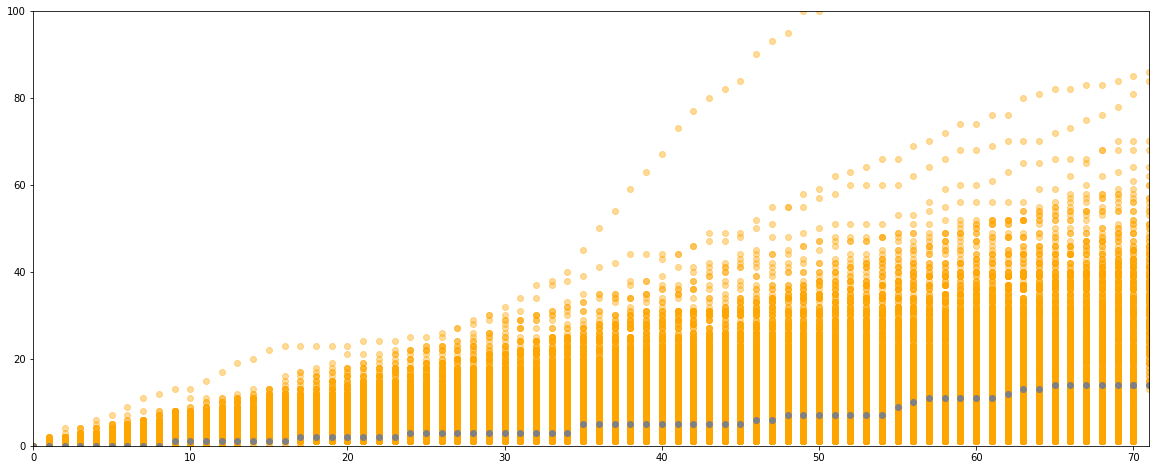

In [55]:
plt.figure(figsize = (20,8))
for j in range(1000):
    plt.plot(timing[j], cumulative[j], 'o', color = 'orange', alpha = 0.4)

plt.plot(summary_time, summary_cum, 'o', color = 'grey')
plt.xlim([0,len_syn])
plt.ylim([0,100])



In [56]:
sun_cum = np.zeros(200)
for k in range(200):
    for j in range(1000):
        if timing[j][-1]<k:
            sun_cum[k] +=0
        else:
            sun_cum[k] += cumulative[j][k]
cumulative = np.array(cumulative)

In [62]:
mat = np.zeros(shape=(1000, len_syn))
for k in range(1000):
    mat[k,:] = cumulative[k][:len_syn]
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

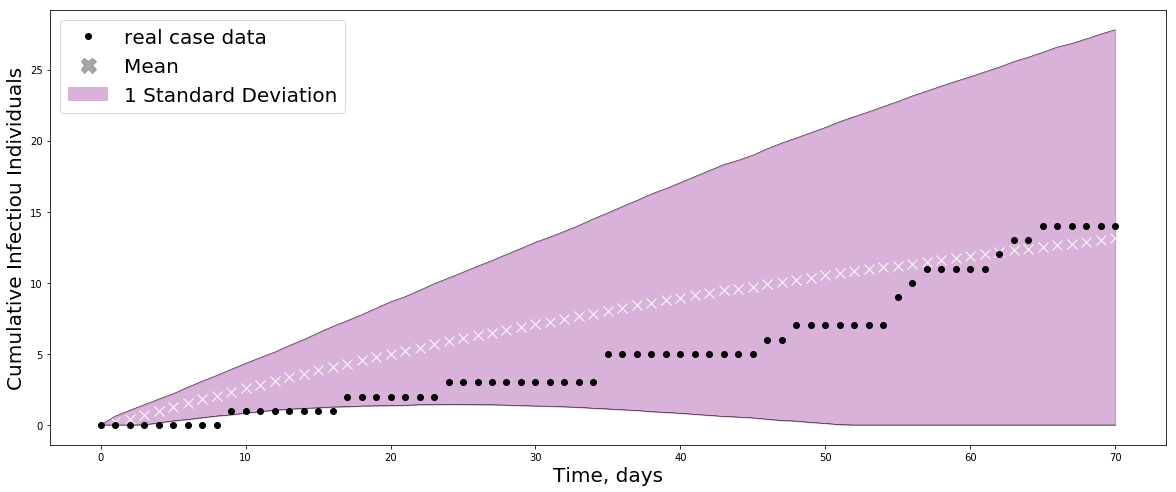

In [71]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(range(len_syn), np.mean(mat, axis = 0), 'x', markersize = 10,linewidth = 6, color = '#fdfdfe', label = 'Mean')
plt.plot(range(len_syn), (np.mean(mat, axis = 0)+np.std(mat, axis = 0)), color ='k', lw=0.5)
plt.plot(range(len_syn), np.maximum((np.mean(mat, axis = 0)-np.std(mat, axis = 0)),0),color ='k', lw=0.5)
plt.fill_between(range(len_syn),  (np.mean(mat, axis = 0)+np.std(mat, axis = 0)), np.maximum((np.mean(mat, axis = 0)-np.std(mat, axis = 0)),0), 1, alpha=0.3, color = 'purple')
true, = ax.plot(summary[0], summary[1], 'o', color = 'black', label = 'real case data')
# leg = ax.legend(fontsize = 20)
plt.ylabel('Cumulative Infectiou Individuals', fontsize = 20)
patch = mpatches.Patch(facecolor='purple', alpha=0.3, linewidth=0, label = '1 Standard Deviation')
blue_line = mlines.Line2D([], [], color='grey', alpha = 0.7, marker='X',
                          markersize=15, linestyle = '', linewidth = 0.2,  label='Mean')
plt.xlabel('Time, days', fontsize = 20)
plt.legend(handles=[true,blue_line, patch], fontsize = 20)

Text(0.5,0,'Time, days')

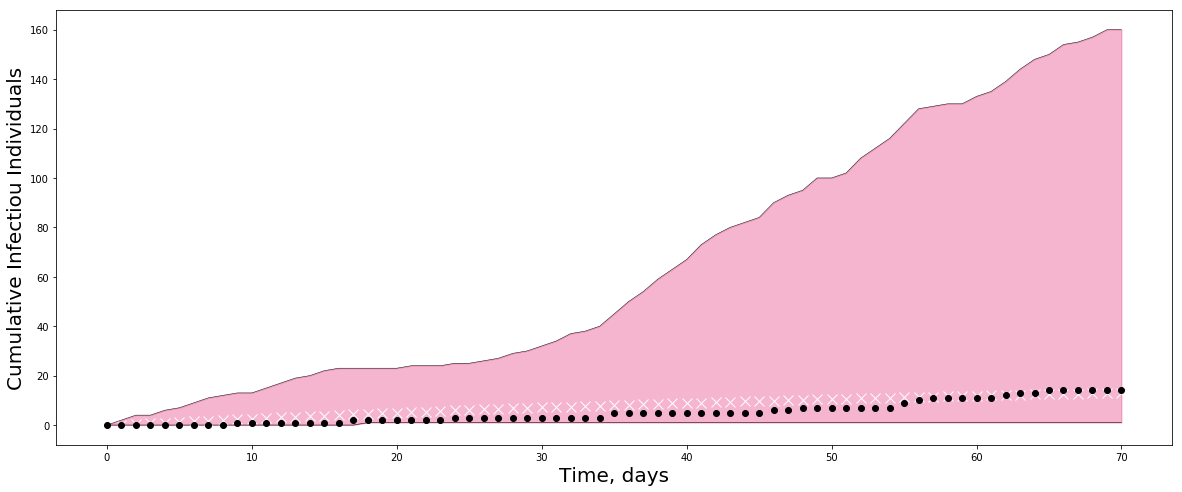

In [59]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(range(len_syn), np.mean(mat, axis = 0), 'x', markersize = 10,linewidth = 6, color = '#fdfdfe', label = 'Mean')
plt.plot(range(len_syn), (np.max(mat, axis = 0)), color ='k', lw=0.5)
plt.plot(range(len_syn), (np.min(mat, axis = 0)),color ='k', lw=0.5)
plt.fill_between(range(len_syn),  (np.max(mat, axis = 0)), np.min(mat, axis = 0), 1, alpha=0.3, color = '#de0c62')
ax.plot(summary[0], summary[1], 'o', color = 'black', label = 'real case data')
# leg = ax.legend(fontsize = 20)
plt.ylabel('Cumulative Infectiou Individuals', fontsize = 20)
plt.xlabel('Time, days', fontsize = 20)

# Error between mean and synthetic data

In [60]:
def returnerror(timestep, cum, sumstat1, sumstat2):
    time = [] #make results of M a step function
    cuminf = [] #steps
    for ind, x in enumerate(timestep):
        if ind < len(timestep)-1:
            time.append((timestep[ind], timestep[ind+1]))
            cuminf.append((cum[ind], cum[ind]))
    time = np.array(time).flatten()
    cuminf = np.array(cuminf).flatten()
    max_inf = max(cuminf)
    max_time = math.ceil(max(time))
#     print(max_inf, max_time, βt, ɛt)
    

    summary_time = sumstat1
#         print(summary_time, max(summary_time[0]), max_time)
    summary_cum = sumstat2
    if max_time> max(summary_time):
        length1 =  np.arange(max(summary_time), max_time +1, 3)
        summary_time = np.append(summary_time, length1)
#         print(summary_time, len( length1))
        summary_cum = np.append(summary_cum, max(sumstat2)*np.ones(len(length1 )))
#         print(summary_cum)
    if max_time < max(summary_time):
        length2 = np.arange(max_time, max(summary_time)+1, 1)
        time = np.append(time,length2)
        cuminf = np.append(cuminf, max_inf*np.ones(len(length2)))
        
    inter_t = np.arange(0, max(summary_time) +1 , 1) #interpolate to daily steps
    inter_cum = np.interp(inter_t, time,cuminf) 
    return np.linalg.norm(summary_cum-inter_cum[summary_time]), inter_t, inter_cum

24.645136680489315

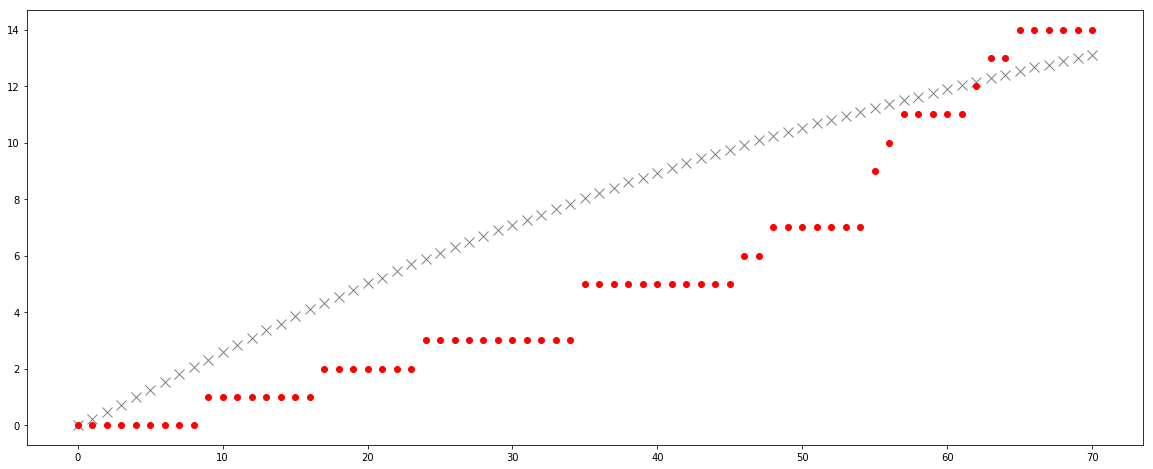

In [61]:
plt.figure(figsize = (20,8))
plt.plot(range(len_syn), np.mean(mat, axis = 0), 'x', markersize = 10,linewidth = 6, color = 'grey', label = 'Mean')
plt.plot(Rec_syn, Cum_syn, 'o', color = 'red')
error = returnerror(range(len_syn), np.mean(mat, axis = 0), Rec_syn, Cum_syn)[0]
# returnerror(range(len_syn), np.mean(mat, axis = 0), Rec_syn, Cum_syn)[2]
error


# Attributes

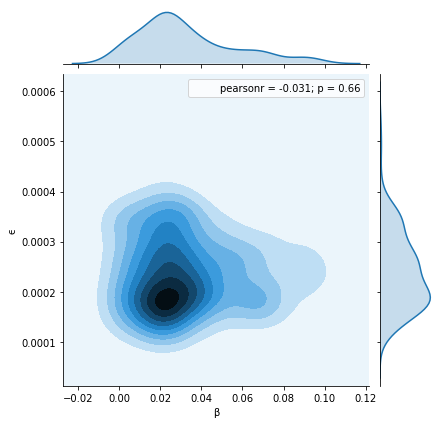

In [62]:
d = {'β': θ[5][:,0], 'ϵ': θ[5][:,1], 'σ': θ[5][:,2], 'μ1': θ[5][:,3], 'μ2': θ[5][:,4]}
df = pd.DataFrame(data = d)
sns.jointplot(x="β", y="ϵ", data=df, kind="kde"); 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/emma/.local/lib/python3.5/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)


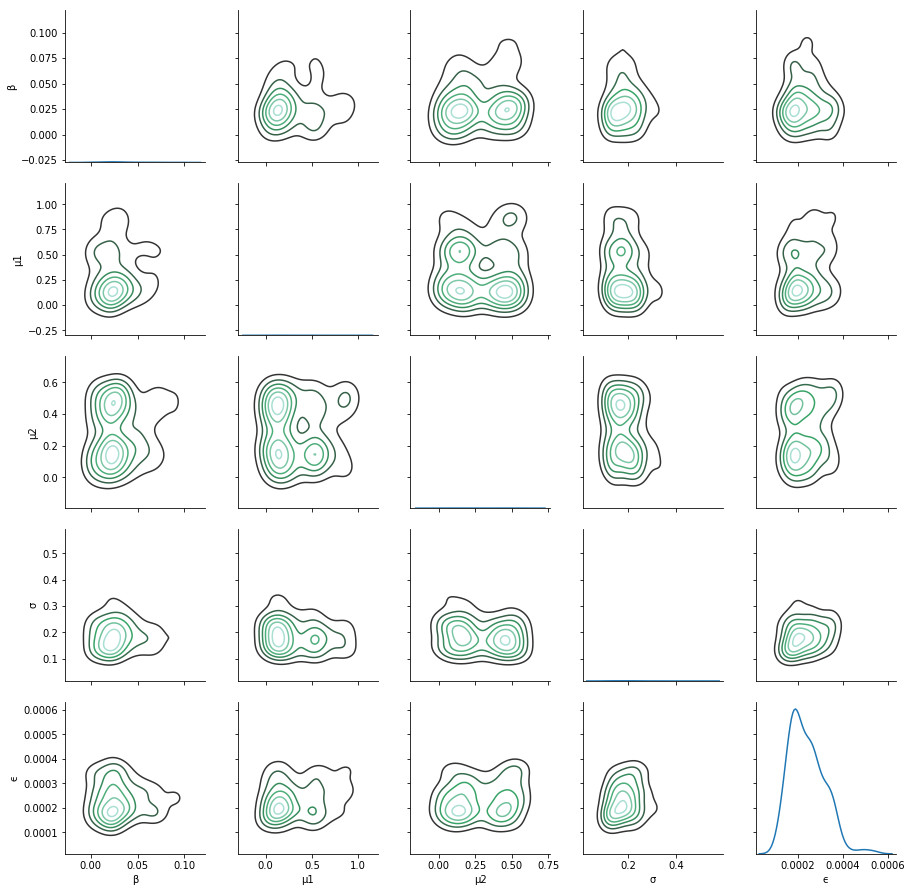

In [63]:
g = sns.PairGrid(df)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6); #pretty much all independent 